<a href="https://colab.research.google.com/github/ZahraFayyaz/3dshape-vqvae-pyTorch/blob/main/3dshape_vqvae.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import modules

In [2]:
import os, h5py, torch, torchvision, timeit
import torch.nn as nn
import numpy as np
from matplotlib import pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torch.optim import Adam

## Modify PyTorch Configuration

In [3]:
# Enable CuDNN benchmark mode for faster runtime optimizations
torch.backends.cudnn.benchmark = True

# Ensure deterministic behavior in CuDNN operations
torch.backends.cudnn.deterministic = True

# Optionally disable CuDNN's tensor core usage if encountering issues
torch.backends.cudnn.enabled = True

# Hyperparameters

In [ ]:
# NUM_LATENT_K = 20                 # Number of codebook entries
# NUM_LATENT_D = 64                 # Dimension of each codebook entries
# BETA = 1.0                        # Weight for the commitment loss

# INPUT_SHAPE = x_train.shape[1:]
# SIZE = None                       # Spatial size of latent embedding
#                                   # will be set dynamically in `build_vqvae

# VQVAE_BATCH_SIZE = 128            # Batch size for training the VQVAE
# VQVAE_NUM_EPOCHS = 20             # Number of epochs
# VQVAE_LEARNING_RATE = 3e-4        # Learning rate
# VQVAE_LAYERS = [16, 32]           # Number of filters for each layer in the encoder

# PIXELCNN_BATCH_SIZE = 128         # Batch size for training the PixelCNN prior
# PIXELCNN_NUM_EPOCHS = 10          # Number of epochs
# PIXELCNN_LEARNING_RATE = 3e-4     # Learning rate
# PIXELCNN_NUM_BLOCKS = 12          # Number of Gated PixelCNN blocks in the architecture
# PIXELCNN_NUM_FEATURE_MAPS = 32    # Width of each PixelCNN block

# Load Data

In [4]:
#connect to google drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
class LoadData_fast(Dataset):
    def __init__(self, data_path, indices, transform=None):
        self.data_path = data_path
        self.transform = transform
        assert os.path.exists(self.data_path), f"images path {self.data_path} does not exist"
        self.data = h5py.File(self.data_path, 'r')
        self.indices = indices  # Store indices for lazy loading

    def __len__(self):
        return len(self.indices)

    def __getitems__(self, index):
        idx = self.indices[index]
        image = self.data['images'][idx]  # Load image on-demand
        label = self.data['labels'][idx]  # Load label on-demand

        # Normalize the image to range [-1, 1] and transpose to [C, H, W] format
        image = 2 * (image.astype(np.float32) / 255.0) - 1
        image = np.transpose(image, (2, 0, 1))

        # Convert to torch tensors
        image = torch.tensor(image, dtype=torch.float32)
        label = torch.tensor(label, dtype=torch.float32)

        return image, label

In [6]:
class Shapes3DDataset(Dataset):
    def __init__(self, split, data_path, transform=None):
        self.data_path = data_path
        assert os.path.exists(self.data_path), f"images path {self.data_path} does not exist"
        self.dataset = h5py.File(self.data_path, 'r')
        if split=='train': self.images = self.dataset['images'][:384_000,:]
        elif split=='test': self.images = self.dataset['images'][384_000:,:]
        # self.labels = self.file['labels']
        self.transform = transform

    def __len__(self):
        return self.images.shape[0]

    def __getitem__(self, idx):
        image = self.images[idx]
        # label = self.labels[idx]

        # Normalize the image to range [-1, 1]
        image = image.astype(np.float32) / 255.0 * 2 - 1
        # Transpose image to fit PyTorch's [C, H, W] format
        image = np.transpose(image, (2, 0, 1))

        image = torch.tensor(image, dtype=torch.float32)
        # label = torch.tensor(label, dtype=torch.float32)

        return image, None

# Custom collate function to handle batch loading
def custom_collate_fn(batch):
    images = torch.stack([item[0] for item in batch])
    # labels = torch.stack([item[1] for item in batch])
    return images, None


# Initialize the dataset and dataloader
# dataset = Shapes3DDataset(data_path='/home/mohsen/Desktop/Academia/RUB Research Projects/INI/data/3dshapes/3dshapes.h5')
# dataloader = DataLoader(dataset, batch_size=128, shuffle=True, num_workers=8, pin_memory=True, collate_fn=custom_collate_fn)

## Sample & Split Data

In [7]:
#make the split_sample_data function faster
def split_sample_data_fast(n_samples=480_000, seed=42, n_sub_samples=None):
    np.random.seed(seed)

    if n_sub_samples:
        # Generate a list of n_sub_samples random integers between 0 and n_samples-1
        indices = np.random.randint(0, n_samples, size=n_sub_samples)
    else:
        # Generate an array between 0 and n_samples-1
        indices = np.arange(n_samples)

    # Calculate the number of test indices (20% of the list) and extract the test indices
    n_test = int(len(indices) * 0.2)
    test_indices = np.random.choice(indices, size=n_test, replace=False)

    # Create a boolean mask to identify train indices
    mask = np.isin(indices, test_indices, invert=True)
    train_indices = indices[mask]

    # Sort indices if required (optional)
    train_indices.sort()
    test_indices.sort()

    return train_indices.tolist(), test_indices.tolist()

# VQVAE Class

In [49]:
class VQVAE(nn.Module):
    def __init__(self):
        super().__init__() #super(VQVAE, self) is a python2 style for running super and call __init__() method of the parent class. In python3 we can use this new typping style.
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 24, 4, stride=2, padding=1), # inp_channels=1, out_channels=16, kernel_size (size of receptive field)=4 => width & height output = 14. We have also 16 Weight matrices that result in having an output of shape [14,14,16]
            nn.BatchNorm2d(24),
            nn.ReLU(),
            nn.Conv2d(24, 48, 4, stride=2, padding=1),
            nn.BatchNorm2d(48),
            nn.ReLU(),
        )

        self.pre_quant_conv = nn.Conv2d(48, 64, kernel_size=1) # https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html
        self.embedding = nn.Embedding(num_embeddings=20, embedding_dim=64) # 20 codebook vectors of size 64 - For more info regarding Embedding documentation: https://pytorch.org/docs/stable/generated/torch.nn.Embedding.html
        self.post_quant_conv = nn.Conv2d(64, 48, kernel_size=1)

        # Commitment Loss Beta
        self.beta = 0.2

        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(48, 24, 4, stride=2, padding=1),
            nn.BatchNorm2d(24),
            nn.ReLU(),
            nn.ConvTranspose2d(24, 3, 4, stride=2, padding=1),
            nn.Tanh(),
        )


    def forward(self, x):
        # B, C, H, W
        encoded_output = self.encoder(x)
        quant_input = self.pre_quant_conv(encoded_output)

        ## Quantization
        B, C, H, W = quant_input.shape # stands for batch_size, output channel of convolution before quantization, height, and width
        quant_input = quant_input.permute(0, 2, 3, 1) # replace position of B, C, H, W to B, H, W, C
        quant_input = quant_input.reshape((quant_input.size(0), -1, quant_input.size(-1))) # flatten the data shape to B, W*H, C

        # Compute pairwise distances
        dist = torch.cdist(quant_input, self.embedding.weight[None, :].repeat((quant_input.size(0), 1, 1)))

        # Find index of nearest embedding
        min_encoding_indices = torch.argmin(dist, dim=-1)

        # Select the embedding weights
        quant_out = torch.index_select(self.embedding.weight, 0, min_encoding_indices.view(-1)) # index_select selects the nearest embedding weights based on min_encoding_indices.
        quant_input = quant_input.reshape((-1, quant_input.size(-1)))

        # Compute losses
        commitment_loss = torch.mean((quant_out.detach() - quant_input)**2) # commitment loss pushes z_x toward embedding space and updates encoded space. It ensures that it does not grow faster than embedding space
        codebook_loss = torch.mean((quant_out - quant_input.detach())**2) # codebook loss pushes e_i toward z_x and update embedding space
        quantize_losses = codebook_loss + self.beta*commitment_loss

        # Ensure straight through gradient
        quant_out = quant_input + (quant_out - quant_input).detach()

        # Reshaping back to original input shape
        quant_out = quant_out.reshape((B, H, W, C)).permute(0, 3, 1, 2) # Changes the shpae of quant_input from [B, H, W, C] to [B, C, H, W]
        min_encoding_indices = min_encoding_indices.reshape((-1, quant_out.size(-2), quant_out.size(-1)))


        ## Decoder part
        decoder_input = self.post_quant_conv(quant_out)
        output = self.decoder(decoder_input)
        return quant_out,output, quantize_losses

# VQVAE Implementation

In [123]:
def train_vqvae(path='/content/drive/MyDrive/Data/3dshapes.h5', device='cuda'):
    train_dataset = Shapes3DDataset(split='train', data_path=path)
    test_dataset = Shapes3DDataset(split='test', data_path=path)

    train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True, num_workers=8, pin_memory=True, collate_fn=custom_collate_fn)
    test_loader = DataLoader(test_dataset, batch_size=256, shuffle=True, num_workers=8, pin_memory=True, collate_fn=custom_collate_fn)

    # Initialize model, optimizer, and loss function
    model = VQVAE().to(device)
    optimizer = Adam(model.parameters(), lr=1E-3)
    criterion = torch.nn.MSELoss()

    num_epochs = 60
    alpha=10
    for epoch_idx in range(num_epochs):
        model.train()  # Set model to training mode
        for im, label in train_loader:
            im = im.float().to(device, non_blocking=True)
            optimizer.zero_grad()
            quant_out, out, quantize_loss = model(im)
            recon_loss = criterion(out, im)
            loss = alpha*recon_loss + quantize_loss
            loss.backward()
            optimizer.step()

        print(f'Epoch {epoch_idx+1}: Recon Loss: {recon_loss.item()}, Quantize Loss: {quantize_loss.item()}, Total Loss: {loss.item()}')
    print('Done Training...')

    model.eval()  # Set model to evaluation mode
    with torch.no_grad():
        total_recon_loss = 0
        total_quantize_loss = 0
        for im, label in test_loader:
            im = im.float().to(device, non_blocking=True)
            quant_out, out, quantize_loss = model(im)
            recon_loss = criterion(out, im)
            total_recon_loss += recon_loss.item()
            total_quantize_loss += quantize_loss.item()

        print(f'Validation: Recon Loss: {total_recon_loss/len(test_loader)}, Quantize Loss: {total_quantize_loss/len(test_loader)}')


    model.eval()
    print('Done Reconstruction ...')
    return model

In [124]:
 # device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# train_indices, test_indices = split_sample_data_fast(n_samples=480_000, seed=42, n_sub_samples=1000)
model= train_vqvae()

Epoch 1: Recon Loss: 0.05902785062789917, Quantize Loss: 7.296901226043701, Total Loss: 7.887179851531982
Epoch 2: Recon Loss: 0.024802401661872864, Quantize Loss: 1.1079241037368774, Total Loss: 1.3559480905532837
Epoch 3: Recon Loss: 0.022124722599983215, Quantize Loss: 1.318993330001831, Total Loss: 1.5402405261993408
Epoch 4: Recon Loss: 0.020255349576473236, Quantize Loss: 1.27303946018219, Total Loss: 1.4755929708480835
Epoch 5: Recon Loss: 0.01996523141860962, Quantize Loss: 1.463899850845337, Total Loss: 1.663552165031433
Epoch 6: Recon Loss: 0.018195902928709984, Quantize Loss: 1.5961525440216064, Total Loss: 1.7781115770339966
Epoch 7: Recon Loss: 0.016772236675024033, Quantize Loss: 1.6593360900878906, Total Loss: 1.8270584344863892
Epoch 8: Recon Loss: 0.01766074262559414, Quantize Loss: 1.7585569620132446, Total Loss: 1.935164451599121
Epoch 9: Recon Loss: 0.01656254008412361, Quantize Loss: 1.8316346406936646, Total Loss: 1.9972600936889648
Epoch 10: Recon Loss: 0.0166206

In [125]:
path='/content/drive/MyDrive/Data/3dshapes.h5'
test_dataset = Shapes3DDataset(split='test', data_path=path)
device='cuda'
test_loader = DataLoader(test_dataset, batch_size=256, shuffle=True, num_workers=8, pin_memory=True, collate_fn=custom_collate_fn)
model.eval()  # Set model to evaluation mode
criterion = torch.nn.MSELoss()
with torch.no_grad():
    total_recon_loss = 0
    total_quantize_loss = 0
    for im, label in test_loader:
        im = im.float().to(device, non_blocking=True)
        quant_out, out, quantize_loss = model(im)
        recon_loss = criterion(out, im)
        total_recon_loss += recon_loss.item()
        total_quantize_loss += quantize_loss.item()

In [126]:
idxs = torch.randint(0, len(test_dataset), (100, )) # Randomly sample indices for reconstruction.
ims = torch.cat([test_dataset[idx][0][None, :] for idx in idxs]).float() # Create a batch of images from the test set using sampled indices.
ims = ims.to(device)

quant_out,generated_im, _ = model(ims) # Generate reconstructed images.
ims = (ims+1)/2
generated_im = (generated_im + 1) / 2  # Normalize to [0, 1] for visualization

## Transform to original value to retrieve colorized data
ims = ims * 255.0  # Scale to [0, 255]
generated_im = generated_im * 255.0  # Scale to [0, 255]
ims = ims.cpu().numpy().astype(np.uint8)
generated_im = generated_im.detach().cpu().numpy().astype(np.uint8)  # Detach before converting to NumPy

# combined_images = torch.hstack([ims, generated_im])
combined_images = np.concatenate((ims, generated_im), axis=3)

# Rearrange to a grid
combined_images = torch.tensor(combined_images).permute(0, 1, 2, 3)  # Change to [batch, channels, height, width]

grid = torchvision.utils.make_grid(combined_images, nrow=10, padding=2)

img = torchvision.transforms.ToPILImage()(grid)
#img.save('/content/drive/My Drive/INI - Generative Episodic Memory/reconstruction.png')


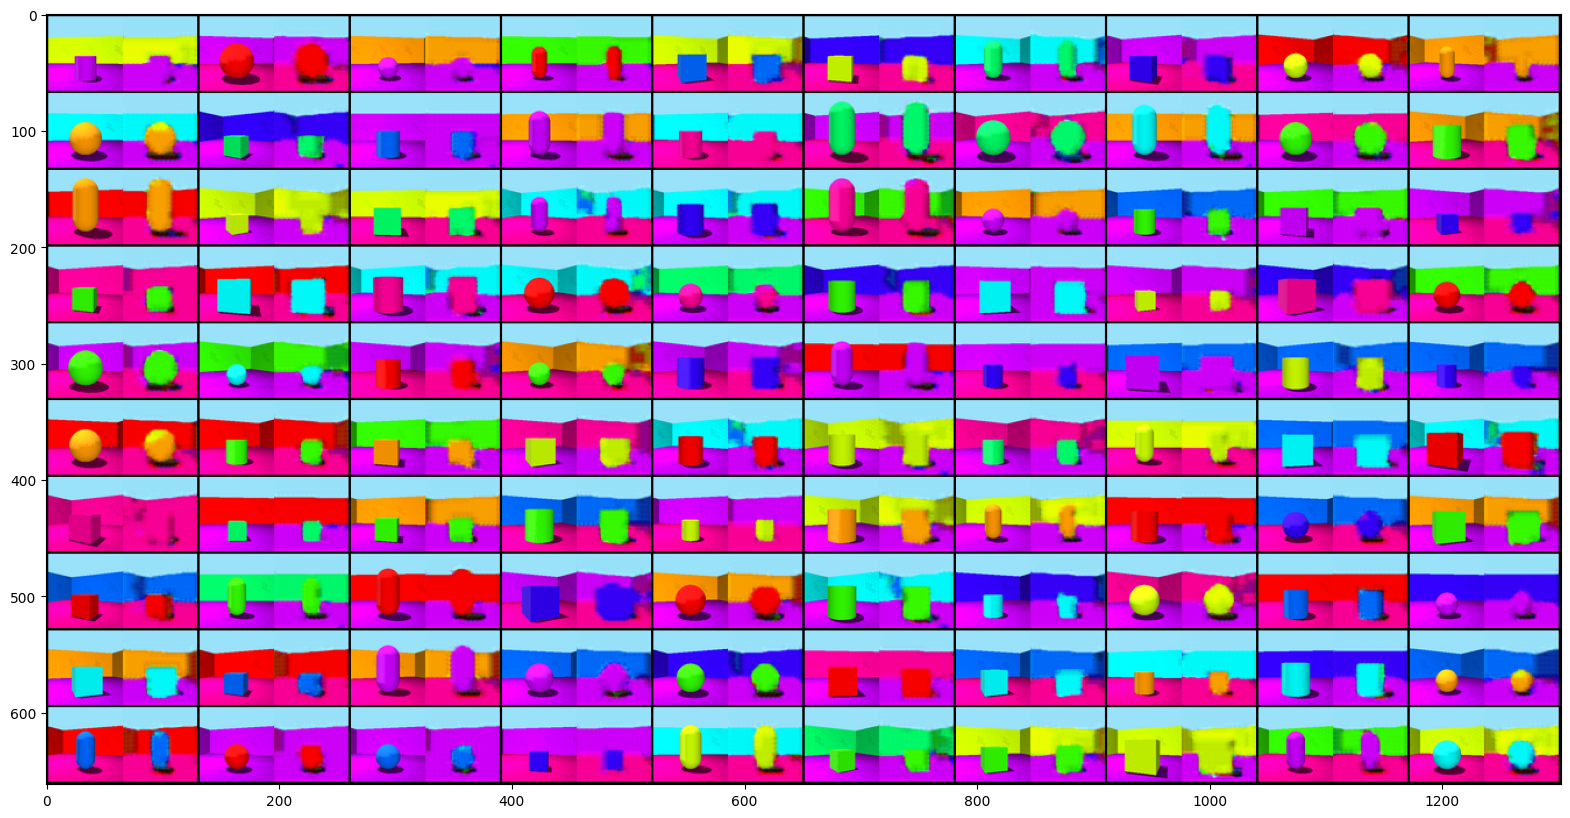

In [127]:
#plot the rexonstructions in a large figure
plt.figure(figsize=(20, 10))
plt.imshow(img)

In [128]:
quantized=quant_out.detach().cpu().numpy()
embs=model.embedding.weight.detach().cpu().numpy()

In [152]:
#replace each codebook vector in the first diemnsion of the quntized vector with an index in the range 0 to 20
indices = np.argmax(np.all(np.isclose(np.moveaxis(quantized, 1,-1)[...,None], np.expand_dims(embs.T, axis=tuple(range(len(quantized.shape)-1)))), axis=-2), axis=-1)

In [ ]:
#alrernative way to do that:
"""
def tensor_to_codebook_index(tensor, codebook):
    # Reshape tensor to (100 * 16 * 16, 64)
    num_samples, depth, height, width = tensor.shape
    reshaped_tensor = tensor.transpose(0, 2, 3, 1).reshape(-1, depth)

    # Compute the squared Euclidean distances between each flattened vector and each codebook vector
    distances = np.linalg.norm(reshaped_tensor[:, np.newaxis] - codebook, axis=2)

    # Find the index of the closest codebook vector for each flattened vector
    indexes = np.argmin(distances, axis=1)

    # Reshape indexes back to the original (100, 16, 16) shape
    indexes = indexes.reshape(num_samples, height, width)

    return indexes
    """


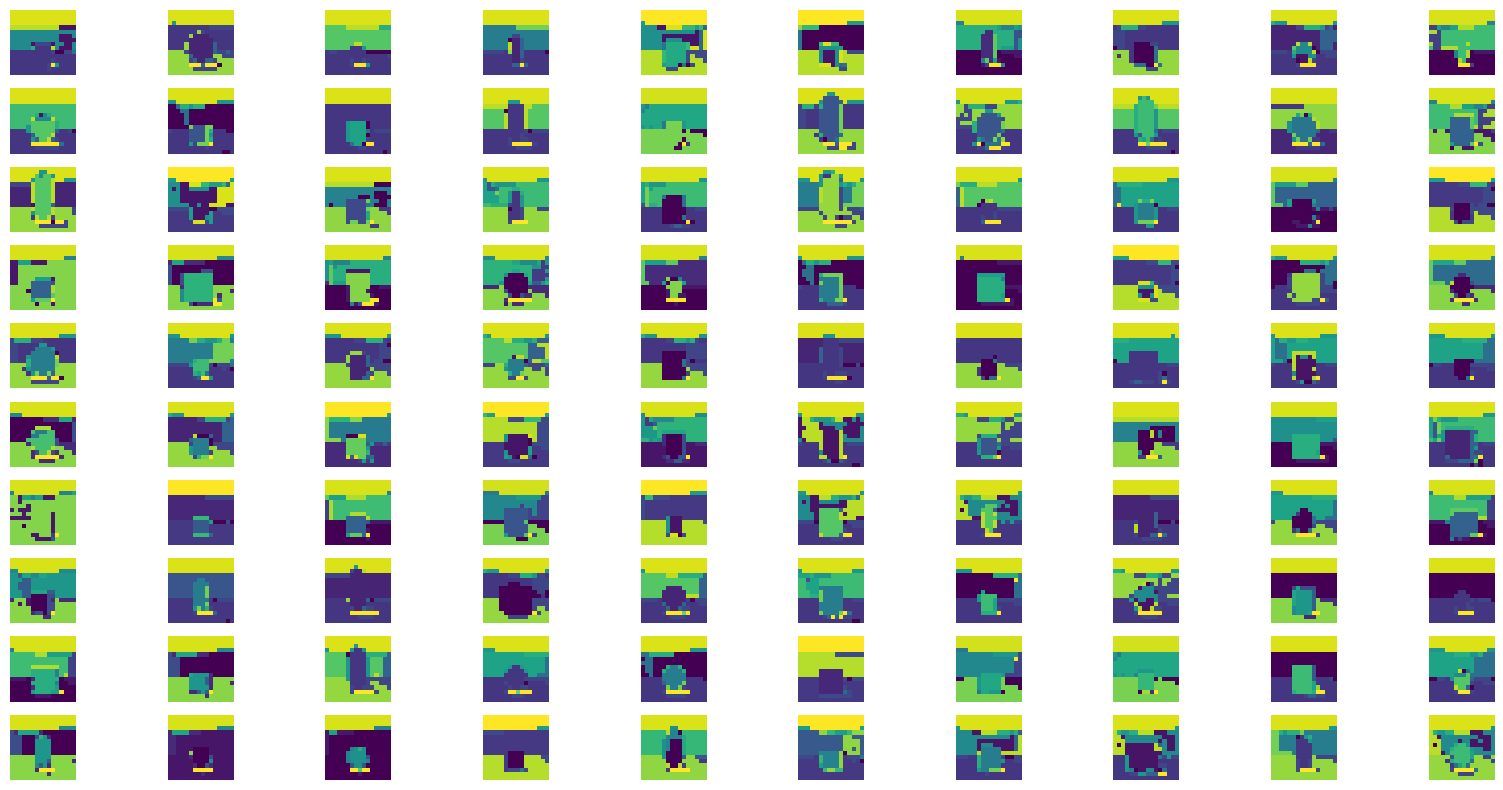

In [153]:
#plot a quantized image

plt.figure(figsize=(20, 10))
for i in range(100):
    plt.subplot(10, 10, i+1)
    plt.imshow(indices[i])
    plt.axis('off')

In [132]:
np.unique(indices)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19])

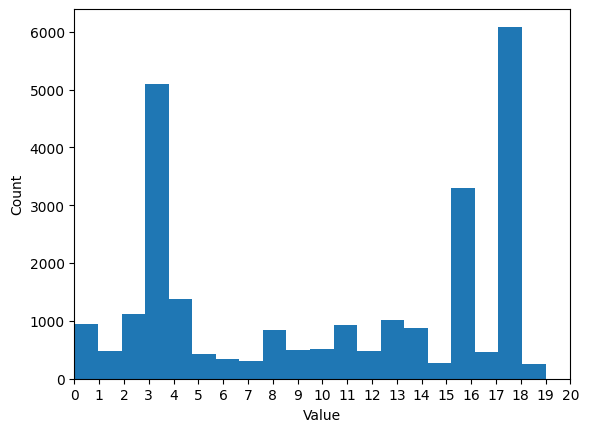

In [133]:
plt.hist(indices.flatten(), bins=20)
#set x limits
plt.xlim([0, 20])
plt.xticks(range(21))
plt.xlabel('Value')
plt.ylabel('Count')
plt.show()

In [ ]:
##todos: img --> z_e --> z_q --> decoded_img
## 1. add encoder function to get z_e (encoder output) for a given image
## 2. add quntize function to get z_q (quantized output) for a given encoder output
## 3. add a function to decode a given quantized latenet vector
## 4. add a function to save and load weights of the model


##transformer

In [135]:
path='/content/drive/MyDrive/Data/3dshapes.h5'
device='cuda'
train_dataset = Shapes3DDataset(split='train', data_path=path)
test_dataset = Shapes3DDataset(split='test', data_path=path)

train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True, num_workers=8, pin_memory=True, collate_fn=custom_collate_fn)
test_loader = DataLoader(test_dataset, batch_size=256, shuffle=True, num_workers=8, pin_memory=True, collate_fn=custom_collate_fn)


AttributeError: 'Shapes3DDataset' object has no attribute 'to'

In [170]:
all_quantized = []
with torch.no_grad():
    for batch_idx, (im, label) in enumerate(train_loader):
        im = im.float().to(device, non_blocking=True)
        quant_out_train, _, _ = model(im)
        quants=quant_out_train.detach().cpu().numpy()
        indices = np.argmax(np.all(np.isclose(np.moveaxis(quants, 1,-1)[...,None], np.expand_dims(embs.T, axis=tuple(range(len(quants.shape)-1)))), axis=-2), axis=-1)
        all_quantized.append(indices)



In [176]:
train_quantized=np.concatenate(all_quantized, axis=0)

In [ ]:
## 1. make a function to save the indexes of the quantized vector (latent indexes) for test and train set


In [179]:
all_quantized = []
with torch.no_grad():
    for batch_idx, (im, label) in enumerate(test_loader):
        im = im.float().to(device, non_blocking=True)
        quant_out_test, _, _ = model(im)
        quants=quant_out_test.detach().cpu().numpy()
        indices = np.argmax(np.all(np.isclose(np.moveaxis(quants, 1,-1)[...,None], np.expand_dims(embs.T, axis=tuple(range(len(quants.shape)-1)))), axis=-2), axis=-1)
        all_quantized.append(indices)


In [182]:
test_quantized=np.concatenate(all_quantized, axis=0)

In [183]:
np.save('/content/drive/MyDrive/Data/train_quantized.npy', train_quantized)
np.save('/content/drive/MyDrive/Data/test_quantized.npy', test_quantized)
np.save('/content/drive/MyDrive/Data/embs.npy', embs)